# 숙명여자대학교 기계시스템학부 딥러닝 2025: Lab3

## Topic: **Autoencoder & CNN with GAP & Transfer Learning**
## (강사: 심주용)


# Autoencoder

## Data Loading and Preparation
In this part, we load the MNIST dataset, which consists of handwritten digits, and prepare it for training and testing. We use PyTorch's datasets and transforms modules to download and transform the data into a suitable format. The data is filtered to include only the digits 1, 5, and 6. Each image is converted to a tensor and flattened since our neural network will use fully connected layers. Normalization is applied to the images by scaling pixel values to the range [0, 1]. This process helps in reducing the complexity of the model's calculations and improves the training efficiency.

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Select only digits 1, 5, 6 for training and testing
train_mask = (mnist.targets == 1) | (mnist.targets == 5) | (mnist.targets == 6)
test_mask = (mnist_test.targets == 1) | (mnist_test.targets == 5) | (mnist_test.targets == 6)

train_imgs = mnist.data[train_mask].float() / 255
train_labels = mnist.targets[train_mask]
test_imgs = mnist_test.data[test_mask].float() / 255
test_labels = mnist_test.targets[test_mask]

print(f"The number of training images: {train_imgs.shape[0]}, shape: {train_imgs.shape}")
print(f"The number of testing images: {test_imgs.shape[0]}, shape: {test_imgs.shape}")


100%|██████████| 9.91M/9.91M [00:11<00:00, 900kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.55MB/s]


The number of training images: 18081, shape: torch.Size([18081, 28, 28])
The number of testing images: 2985, shape: torch.Size([2985, 28, 28])


## Define Model Structure and Training
Here, we define the structure of our autoencoder, which consists of an encoder and a decoder. The encoder compresses the input image into a lower-dimensional latent space, while the decoder reconstructs the image from the latent space representation. We use fully connected layers (nn.Linear) with ReLU activations for both parts. The autoencoder class combines these two components. We then compile the model using the Adam optimizer and mean squared error loss function, which is common for reconstruction tasks. The training process involves feeding the input data through the autoencoder to generate reconstructed images and updating the model weights to minimize the reconstruction error.

In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# Load and transform data
transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x))])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Filter data to get only digits 1, 5, and 6
def filter_indices(dataset, digits):
    indices = []
    for index in range(len(dataset)):
        if dataset.targets[index] in digits:
            indices.append(index)
    return indices

train_indices = filter_indices(mnist_train, [1, 5, 6])
test_indices = filter_indices(mnist_test, [1, 5, 6])

# Create subsets
train_data = Subset(mnist_train, train_indices)
test_data = Subset(mnist_test, test_indices)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
28*28

784

In [ ]:
# Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 500),
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.ReLU(),
            nn.Linear(300, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 300),
            nn.ReLU(),
            nn.Linear(300, 500),
            nn.ReLU(),
            nn.Linear(500, 28*28)
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder and optimizer
autoencoder = Autoencoder()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
for epoch in range(10):
    for batch, (data, _) in enumerate(train_loader):
        data = data.view(-1, 28*28)  # Flatten the images
        optimizer.zero_grad()
        output = autoencoder(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f'Epoch {epoch+1}, Batch {batch}, Loss: {loss.item()}')

Epoch 1, Batch 0, Loss: 0.09782136976718903
Epoch 1, Batch 100, Loss: 0.03147619217634201
Epoch 1, Batch 200, Loss: 0.03127695992588997
Epoch 2, Batch 0, Loss: 0.02620445378124714
Epoch 2, Batch 100, Loss: 0.030409835278987885
Epoch 2, Batch 200, Loss: 0.02791636250913143
Epoch 3, Batch 0, Loss: 0.02870560623705387
Epoch 3, Batch 100, Loss: 0.027154801413416862
Epoch 3, Batch 200, Loss: 0.028741754591464996
Epoch 4, Batch 0, Loss: 0.028903910890221596
Epoch 4, Batch 100, Loss: 0.026471829041838646
Epoch 4, Batch 200, Loss: 0.026419369503855705
Epoch 5, Batch 0, Loss: 0.025418803095817566
Epoch 5, Batch 100, Loss: 0.02771618403494358
Epoch 5, Batch 200, Loss: 0.025055374950170517
Epoch 6, Batch 0, Loss: 0.024321701377630234
Epoch 6, Batch 100, Loss: 0.02484101429581642
Epoch 6, Batch 200, Loss: 0.02384422905743122
Epoch 7, Batch 0, Loss: 0.025636447593569756
Epoch 7, Batch 100, Loss: 0.021159959957003593
Epoch 7, Batch 200, Loss: 0.024562710896134377
Epoch 8, Batch 0, Loss: 0.0288088154

## Evaluate and Visualize Results
After training, we evaluate the model's performance by visualizing how well it can separate the different digits in the latent space. We randomly select a subset of the test images, pass them through the encoder to obtain their latent representations, and plot these in a scatter plot. Each digit type is represented with a different color. This visualization helps in understanding the quality of the learned representations and how well the model can distinguish between different digits based on their latent features.

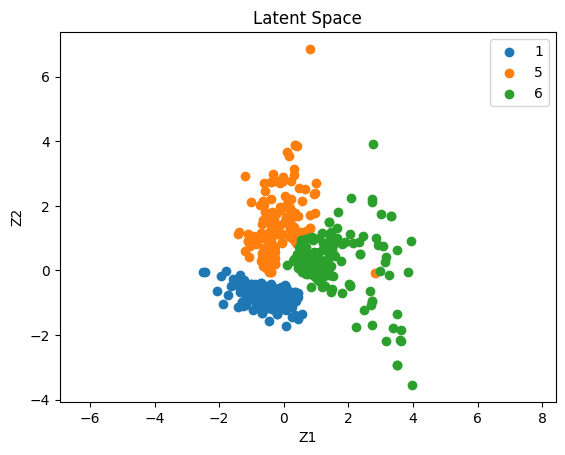

In [ ]:
# Evaluate on test data
autoencoder.eval()
with torch.no_grad():
    idx = np.random.randint(0, len(test_labels), 500)
    test_x = test_imgs[idx]
    test_y = test_labels[idx]
    test_latent = autoencoder.encoder(test_x.reshape(-1, 28*28))

    plt.figure()
    plt.scatter(test_latent[:, 0][test_y == 1], test_latent[:, 1][test_y == 1], label='1')
    plt.scatter(test_latent[:, 0][test_y == 5], test_latent[:, 1][test_y == 5], label='5')
    plt.scatter(test_latent[:, 0][test_y == 6], test_latent[:, 1][test_y == 6], label='6')
    plt.title('Latent Space')
    plt.xlabel('Z1')
    plt.ylabel('Z2')
    plt.legend()
    plt.axis('equal')
    plt.show()


## Generate New Data and Visualize
In the final part, we demonstrate the generative capability of the autoencoder. We manually define new points in the latent space and use the decoder to generate images from these points. This shows how the decoder part of the autoencoder can create new images that resemble the training data, based on the learned features in the latent space. The resulting images are then plotted alongside the latent space to show the correlation between the latent representation and the reconstructed images.

In [ ]:
img = autoencoder.decoder(torch.tensor([[1.0, 0.0],[3.,2.]]))[-1].reshape(28,28)

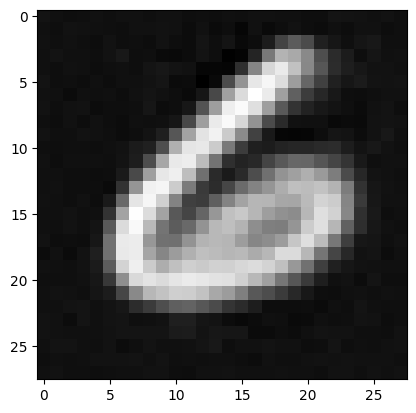

In [ ]:
# prompt: plot the img

plt.imshow(img.detach().numpy(), cmap='gray')
plt.show()


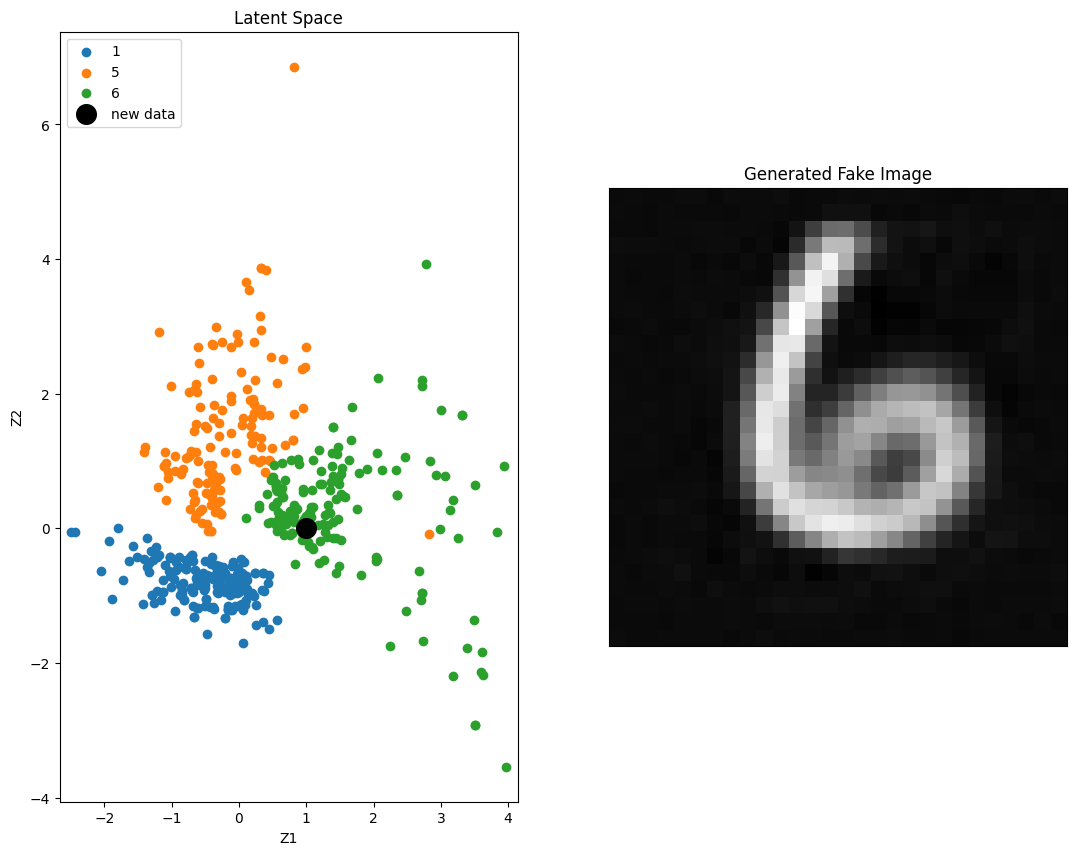

In [ ]:
# Generate new data
new_data = torch.tensor([[1.0, 0.0]])
with torch.no_grad():
    fake_image = autoencoder.decoder(new_data)

    plt.figure(figsize=(13, 10))
    plt.subplot(1, 2, 1)
    plt.scatter(test_latent[:, 0][test_y == 1], test_latent[:, 1][test_y == 1], label='1')
    plt.scatter(test_latent[:, 0][test_y == 5], test_latent[:, 1][test_y == 5], label='5')
    plt.scatter(test_latent[:, 0][test_y == 6], test_latent[:, 1][test_y == 6], label='6')
    plt.scatter(new_data[:, 0], new_data[:, 1], c='k', marker='o', s=200, label='new data')
    plt.title('Latent Space')
    plt.xlabel('Z1')
    plt.ylabel('Z2')
    plt.legend(loc=2)
    plt.axis('equal')

    plt.subplot(1, 2, 2)
    plt.imshow(fake_image.reshape(28, 28), cmap='gray')
    plt.title('Generated Fake Image')
    plt.xticks([])
    plt.yticks([])
    plt.show()


# CNN MNIST Example

Here's a complete PyTorch code snippet for classifying the MNIST dataset using a Convolutional Neural Network (CNN). This example covers the full process: loading the data, defining the model, training the model, and evaluating its performance.

## CNN with Dropout
Step-by-step tutorial on how to perform MNIST classification using PyTorch. MNIST is a dataset of handwritten digits, commonly used for training various image processing systems. This dataset contains 60,000 training images and 10,000 testing images, each being a 28x28 pixel grayscale image of a digit from 0 to 9.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np

# Set seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Step 1: Define the transformations and load the MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset_full = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True, transform=transform)
# Reduce the training set to 10%
num_train = len(trainset_full)
indices = list(range(num_train))
np.random.shuffle(indices)
subset_indices = indices[:int(0.001 * num_train)]
trainset = Subset(trainset_full, subset_indices)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset_full = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)
num_test = len(testset_full)
indices = list(range(num_test))
np.random.shuffle(indices)
subset_indices = indices[:int(0.05 * num_test)]
testset = Subset(testset_full, subset_indices)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

print('num_train', num_train, 'num_test', num_test)

num_train 60000 num_test 10000


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1: Train Loss = 2.3041, Train Accuracy = 5.00%, Test Accuracy = 19.00%
Epoch 2: Train Loss = 2.2503, Train Accuracy = 18.33%, Test Accuracy = 24.40%
Epoch 3: Train Loss = 2.1345, Train Accuracy = 21.67%, Test Accuracy = 37.80%
Epoch 4: Train Loss = 2.0373, Train Accuracy = 21.67%, Test Accuracy = 41.00%
Epoch 5: Train Loss = 1.8357, Train Accuracy = 45.00%, Test Accuracy = 45.40%
Epoch 6: Train Loss = 1.5791, Train Accuracy = 60.00%, Test Accuracy = 47.20%
Epoch 7: Train Loss = 1.4402, Train Accuracy = 68.33%, Test Accuracy = 47.00%
Epoch 8: Train Loss = 1.1669, Train Accuracy = 78.33%, Test Accuracy = 46.80%
Epoch 9: Train Loss = 1.0265, Train Accuracy = 80.00%, Test Accuracy = 49.00%
Epoch 10: Train Loss = 0.9728, Train Accuracy = 76.67%, Test Accuracy = 51.80%
Epoch 11: Train Loss = 0.9050, Train Accuracy = 73.33%, Test Accuracy = 56.80%
Epoch 12: Train Loss = 0.6955, Train Accuracy = 83.33%, Test Accuracy = 60.00%
Epoch 13: Train Loss = 0.5483, Train Accuracy = 91.67%, Test A

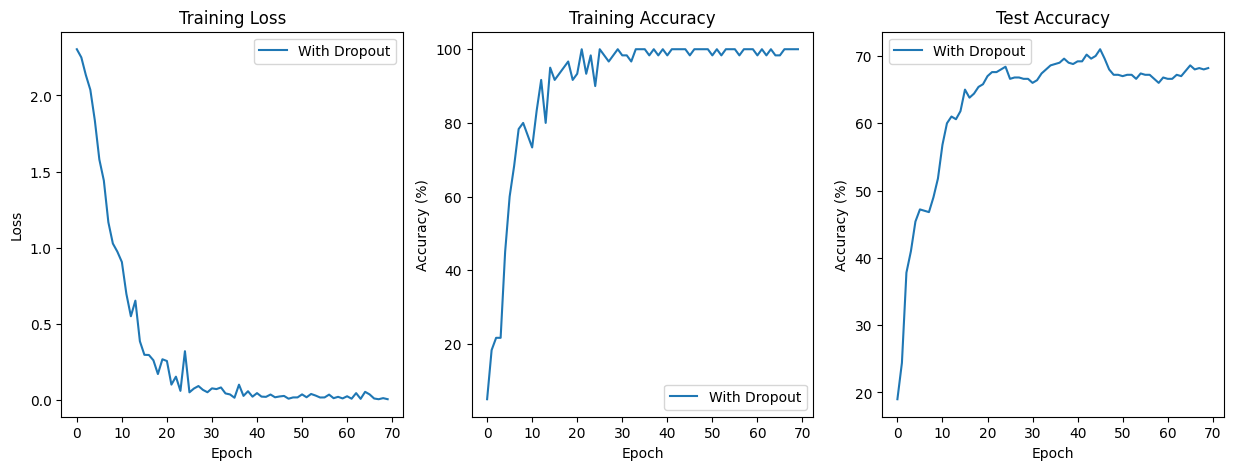

In [ ]:
# Step 2: Define the CNN architecture with and without dropout
class NetWithDropout(nn.Module):
    def __init__(self):
        super(NetWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

# Step 3: Define a Loss function and Optimizer, and Train
def train_and_evaluate(model, optimizer, trainloader, testloader, epochs=70):
    criterion = nn.CrossEntropyLoss()
    training_losses = []
    training_accuracies = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        training_losses.append(running_loss / len(trainloader))
        training_accuracies.append(100 * correct / total)

        # Evaluate on test data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                inputs, labels = data
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_accuracies.append(100 * correct / total)
        print(f'Epoch {epoch + 1}: Train Loss = {running_loss / len(trainloader):.4f}, Train Accuracy = {training_accuracies[-1]:.2f}%, Test Accuracy = {100 * correct / total:.2f}%')

    return training_losses, training_accuracies, test_accuracies

net_with_dropout = NetWithDropout()

optimizer_with = optim.Adam(net_with_dropout.parameters(), lr=0.001)
loss_with, acc_train_with, acc_test_with = train_and_evaluate(net_with_dropout, \
                                          optimizer_with, trainloader, testloader)

# Plot the learning curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(loss_with, label='With Dropout')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(acc_train_with, label='With Dropout')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(acc_test_with, label='With Dropout')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


With Dropout


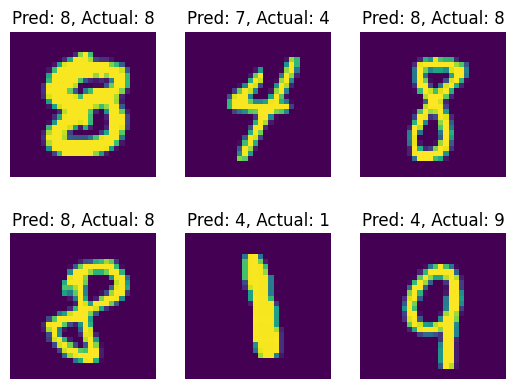

In [ ]:

# Display some images and their predicted labels
def imshow(img):
    # Convert the image to a numpy array and transpose it
    img = img.numpy().transpose((1, 2, 0))
    # Rescale the image to be between 0 and 1
    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    # Display the image
    plt.imshow(img)
    #plt.show()

# Get some random images from the test set
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show the images with their predicted labels
net_with_dropout.eval()
outputs = net_with_dropout(images)
_, predicted = torch.max(outputs, 1)

print('With Dropout')
for i in range(6):
    plt.subplot(2, 3, i+1)
    imshow(images[i])
    plt.title(f"Pred: {predicted[i].item()}, Actual: {labels[i].item()}")
    plt.axis('off')
plt.show()

In [ ]:
# prompt: count the total number of learnable parameters
total_params = sum(p.numel() for p in net_with_dropout.parameters())
print(f"Total Parameters: {total_params/1000/1000} M")

# prompt: save the model with the name including dropout
torch.save(net_with_dropout.state_dict(), 'minst_net_with_dropout.pt')

# 1.2M = 1200k

Total Parameters: 1.1998820000000001 M


## CNN with Global Average Pooling

In [ ]:
# prompt: count the total number of learnable parameters

total_params = sum(p.numel() for p in net_with_gap.parameters())
print(f"Total Parameters: {total_params/1000} k")

# 1.2M = 1200k >>> 331k

Total Parameters: 28.426 k


## CNN with GAP and larger # of parameters

In [ ]:
# prompt: count the total number of learnable parameters

total_params = sum(p.numel() for p in net_with_gap.parameters())
print(f"Total Parameters: {total_params/1000/1000} M")


Total Parameters: 1.2158820000000001 M


# CNN CIFAR10 with or without GAP

### 논의사항
- GAP가 없는 모델은 GAP 모델보다 더 빠르게 학습되지만 최종 테스트, Validation 성능은 GAP 모델이 더 높다.
- BN을 사용하면 모델이 학습될 때 노이즈가 커지지만 학습 속도는 더 빠르다.
(추가 실험 생각해볼 내용)
- BN을 사용하면 learning rate를 증가시킬 수 있다.
- BN을 사용하면 layer를 더 깊게 쌓을 수 있다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, SubsetRandomSampler

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Stratified split setup
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# Step 2: Define the CNN architectures
class GAP_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.global_avg_pool(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Step 3: Define the CNN architectures
class NoGAP_Net(nn.Module):
    def __init__(self):
        super(NoGAP_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(12544, 80)
        self.fc2 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #print(x.shape)
        x = self.fc1(x)
        x = nn.functional.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)


# Function to train and evaluate models
def train_and_evaluate(model, optimizer, trainloader, valloader, testloader, device):
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

    for epoch in range(40):
        # Training Phase
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(trainloader))
        train_accuracies.append(100 * correct / total)

        # Validation Phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_losses.append(val_loss / len(valloader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch+1} - Train Loss: {train_losses[-1]:.3f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.3f}, Val Acc: {val_accuracies[-1]:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies

# Train and Evaluate GAP_Net
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gap_net = GAP_Net().to(device)
nogap_net = NoGAP_Net().to(device)

# prompt: count the total number of learnable parameters
total_params = sum(p.numel() for p in gap_net.parameters())
print(f"GAP_Net Total Parameters: {total_params/1000} k")
total_params = sum(p.numel() for p in nogap_net.parameters())
print(f"NoGAP_Net Total Parameters: {total_params/1000} k")


optimizer_gap = optim.Adam(gap_net.parameters(), lr=0.001)
optimizer_nogap = optim.Adam(nogap_net.parameters(), lr=0.001)

print("Training GAP_Net")
train_loss_gap, train_acc_gap, val_loss_gap, val_acc_gap = train_and_evaluate(gap_net, optimizer_gap, trainloader, valloader, testloader, device)
print("Training NoGAP_Net")
train_loss_nogap, train_acc_nogap, val_loss_nogap, val_acc_nogap = train_and_evaluate(nogap_net, optimizer_nogap, trainloader, valloader, testloader, device)
print('Finished Training')


# Plot results
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(train_loss_gap, label='GAP Train Loss')
plt.plot(val_loss_gap, label='GAP Val Loss')
plt.plot(train_loss_nogap, label='NoGAP Train Loss')
plt.plot(val_loss_nogap, label='NoGAP Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_acc_gap, label='GAP Train Acc')
plt.plot(val_acc_gap, label='GAP Val Acc')
plt.plot(train_acc_nogap, label='NoGAP Train Acc')
plt.plot(val_acc_nogap, label='NoGAP Val Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


# Step 6: Evaluate the network on the test data
correct = 0
total = 0
gap_net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = gap_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'GAP_Net Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

correct = 0
total = 0
nogap_net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = nogap_net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'NoGAP_Net Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')


100%|██████████| 170M/170M [00:03<00:00, 47.6MB/s]


GAP_Net Total Parameters: 1072.138 k
NoGAP_Net Total Parameters: 1023.802 k
Training GAP_Net
Epoch 1 - Train Loss: 1.717, Train Acc: 33.55%, Val Loss: 1.398, Val Acc: 47.98%
Epoch 2 - Train Loss: 1.289, Train Acc: 52.36%, Val Loss: 1.129, Val Acc: 58.70%
Epoch 3 - Train Loss: 1.089, Train Acc: 60.47%, Val Loss: 1.083, Val Acc: 61.04%
Epoch 4 - Train Loss: 0.975, Train Acc: 64.98%, Val Loss: 0.975, Val Acc: 64.54%
Epoch 5 - Train Loss: 0.876, Train Acc: 68.68%, Val Loss: 0.832, Val Acc: 70.22%
Epoch 6 - Train Loss: 0.796, Train Acc: 71.84%, Val Loss: 0.782, Val Acc: 73.14%
Epoch 7 - Train Loss: 0.731, Train Acc: 74.04%, Val Loss: 0.774, Val Acc: 72.80%
Epoch 8 - Train Loss: 0.666, Train Acc: 76.42%, Val Loss: 0.714, Val Acc: 74.74%
Epoch 9 - Train Loss: 0.618, Train Acc: 78.03%, Val Loss: 0.671, Val Acc: 76.80%
Epoch 10 - Train Loss: 0.567, Train Acc: 79.79%, Val Loss: 0.647, Val Acc: 77.14%
Epoch 11 - Train Loss: 0.526, Train Acc: 81.45%, Val Loss: 0.666, Val Acc: 77.16%
Epoch 12 - Tra

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1 - Train Loss: 1.652, Train Acc: 40.09%, Val Loss: 1.276, Val Acc: 55.18%
Epoch 2 - Train Loss: 1.362, Train Acc: 51.18%, Val Loss: 1.098, Val Acc: 61.78%
Epoch 3 - Train Loss: 1.243, Train Acc: 55.88%, Val Loss: 1.030, Val Acc: 63.78%
Epoch 4 - Train Loss: 1.166, Train Acc: 58.88%, Val Loss: 0.985, Val Acc: 65.72%
Epoch 5 - Train Loss: 1.103, Train Acc: 60.82%, Val Loss: 0.956, Val Acc: 67.04%
Epoch 6 - Train Loss: 1.047, Train Acc: 62.71%, Val Loss: 0.907, Val Acc: 68.42%
Epoch 7 - Train Loss: 1.010, Train Acc: 64.14%, Val Loss: 0.894, Val Acc: 68.82%
Epoch 8 - Train Loss: 0.968, Train Acc: 65.66%, Val Loss: 0.893, Val Acc: 68.84%
Epoch 9 - Train Loss: 0.940, Train Acc: 66.47%, Val Loss: 0.885, Val Acc: 68.76%
Epoch 10 - Train Loss: 0.910, Train Acc: 67.46%, Val Loss: 0.884, Val Acc: 68.78%
Epoch 11 - Train Loss: 0.878, Train Acc: 68.39%, Val Loss: 0.883, Val Acc: 68.68%
Epoch 12 - Train Loss: 0.851, Train Acc: 69.23%, Val Loss: 0.869, Val Acc: 69.18%
Epoch 13 - Train Loss: 0.

KeyboardInterrupt: 

```
poch 1 - Training Loss: 0.187, Accuracy: 94.84%, Validation Loss: 0.155, Accuracy: 95.30%
Epoch 2 - Training Loss: 0.054, Accuracy: 98.24%, Validation Loss: 0.088, Accuracy: 97.25%
Epoch 3 - Training Loss: 0.039, Accuracy: 98.79%, Validation Loss: 0.051, Accuracy: 98.70%
Epoch 4 - Training Loss: 0.033, Accuracy: 98.94%, Validation Loss: 0.059, Accuracy: 98.32%
Epoch 5 - Training Loss: 0.028, Accuracy: 99.09%, Validation Loss: 0.054, Accuracy: 98.58%
Epoch 6 - Training Loss: 0.025, Accuracy: 99.21%, Validation Loss: 0.045, Accuracy: 98.72%
Epoch 7 - Training Loss: 0.023, Accuracy: 99.26%, Validation Loss: 0.080, Accuracy: 97.87%
Epoch 8 - Training Loss: 0.021, Accuracy: 99.33%, Validation Loss: 0.041, Accuracy: 98.83%
Epoch 9 - Training Loss: 0.018, Accuracy: 99.43%, Validation Loss: 0.055, Accuracy: 98.55%
Epoch 10 - Training Loss: 0.014, Accuracy: 99.55%, Validation Loss: 0.114, Accuracy: 96.90%
Finished Training
Accuracy of the network on the 10,000 test images: 96.91%
```

# Transfer Learning

## 실습에서 ResNet18의 (i) learnable parameters을 고정한 경우와 (ii) 마지막 3개 Layer만 제외하고 나머지 learnable parameters를 고정한 경우, (iii) 모든 레이어를 고정하지 않은 경우에 대해 학습시키고 결과를 논의하세요.

# 목표: 전체 레이어를 fine-tuning하면 성능이 높아질 수 있으나 데이터가 적은 경우 불리함을 확인한다. 또한, 일부 레이어를 고정하지 않고 모델을 수정할 수 있다.

## 논의사항
- 모두 fix하지 않고 학습시키면 가장 성능이 높다.
- 마지막 일부 레이어를 trainable하게 하면 성능이 미소하게 상승한다.

(추가로 실험 생각해볼 내용)
- MNIST 예제 처럼 데이터를 적게 선별하여 학습시키면 (예, training data의 0.1%만 사용하고, validation data 역시 0.5%만 사용) fine tuning 모델이 overfitting이 일어난다.

## ResNet18 Net_All_Fixed

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models

# Step 1: Load the CIFAR-10 dataset with transformations
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to fit ResNet input
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjusted for 3 channels
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Same stratified split setup
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
targets = trainset.targets
for train_index, val_index in sss.split(np.zeros(len(targets)), targets):
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


# Step 2: Define the CNN architecture with pretrained resnet18
class Net_All_Fixed(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet and modify it
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all the layers in the network
        for param in self.resnet.parameters():
            param.requires_grad = False

        # CIFAR-10 has 10 classes, modify the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)  # Adjust for 10 classes

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_all_fixed = Net_All_Fixed().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_all_fixed = optim.Adam(net_all_fixed.parameters(), lr=0.001)

# Function to train and evaluate a model
def train_and_evaluate(net, optimizer, epochs=10):
  train_losses = []
  train_accuracy = []
  train_losses_iter = []
  train_accuracy_iter = []
  val_losses = []
  val_accuracy = []

  for epoch in range(epochs):
      running_loss_iter = 0.0
      running_loss = 0.0
      correct = 0
      total = 0
      net.train()
      for i, data in enumerate(trainloader):
          inputs, labels = data[0].to(device), data[1].to(device)

          optimizer.zero_grad()

          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          running_loss_iter += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          if i % 200 == 199:  # print and record every 200 mini-batches
              avg_loss = running_loss_iter / 200
              accuracy = 100 * correct / total
              print(f'Epoch {epoch + 1}, Batch {i + 1}, Loss: {avg_loss:.3f}, Accuracy: {accuracy:.2f}%')
              train_losses_iter.append(avg_loss)
              train_accuracy_iter.append(accuracy)
              running_loss_iter = 0.0
              correct = 0
              total = 0

      train_losses.append(running_loss / len(trainloader))
      train_accuracy.append(100 * correct / total)

      # Validation step
      net.eval()
      val_loss = 0.0
      correct = 0
      total = 0
      with torch.no_grad():
          for data in valloader:
              inputs, labels = data[0].to(device), data[1].to(device)
              outputs = net(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      val_losses.append(val_loss / len(valloader))
      val_accuracy.append(100 * correct / total)

      print(f'Epoch {epoch+1} - Training Loss: {train_losses[-1]:.3f}, Accuracy: {train_accuracy[-1]:.2f}%, Validation Loss: {val_losses[-1]:.3f}, Accuracy: {val_accuracy[-1]:.2f}%')

  print('Finished Training')
  return train_losses, train_accuracy, val_losses, val_accuracy

# Train the network
train_loss_all_fixed, train_acc_all_fixed, val_loss_all_fixed, val_acc_all_fixed = \
 train_and_evaluate(net_all_fixed, optimizer_all_fixed)

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
net_all_fixed.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_all_fixed(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all_fixed, '-o',label='Training Loss')
plt.plot(val_loss_all_fixed, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all_fixed,  '-o',label='Training Accuracy')
plt.plot(val_acc_all_fixed, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()



## ResNet18 Net_All_Fixed (Training 2nd)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Batch 200, Loss: 1.185, Accuracy: 63.55%
Epoch 1, Batch 400, Loss: 0.765, Accuracy: 74.91%
Epoch 1, Batch 600, Loss: 0.686, Accuracy: 77.06%
Epoch 1 - Training Loss: 0.849, Accuracy: 76.76%, Validation Loss: 0.629, Accuracy: 78.92%
Epoch 2, Batch 200, Loss: 0.631, Accuracy: 78.51%
Epoch 2, Batch 400, Loss: 0.627, Accuracy: 78.07%
Epoch 2, Batch 600, Loss: 0.624, Accuracy: 78.60%
Epoch 2 - Training Loss: 0.624, Accuracy: 79.39%, Validation Loss: 0.593, Accuracy: 79.68%
Epoch 3, Batch 200, Loss: 0.582, Accuracy: 79.74%
Epoch 3, Batch 400, Loss: 0.605, Accuracy: 79.19%
Epoch 3, Batch 600, Loss: 0.586, Accuracy: 79.66%
Epoch 3 - Training Loss: 0.593, Accuracy: 79.62%, Validation Loss: 0.560, Accuracy: 80.44%
Epoch 4, Batch 200, Loss: 0.583, Accuracy: 80.00%
Epoch 4, Batch 400, Loss: 0.594, Accuracy: 78.93%
Epoch 4, Batch 600, Loss: 0.571, Accuracy: 80.17%
Epoch 4 - Training Loss: 0.581, Accuracy: 79.89%, Validation Loss: 0.558, Accuracy: 80.84%
Epoch 5, Batch 200, Loss: 0.561, Acc

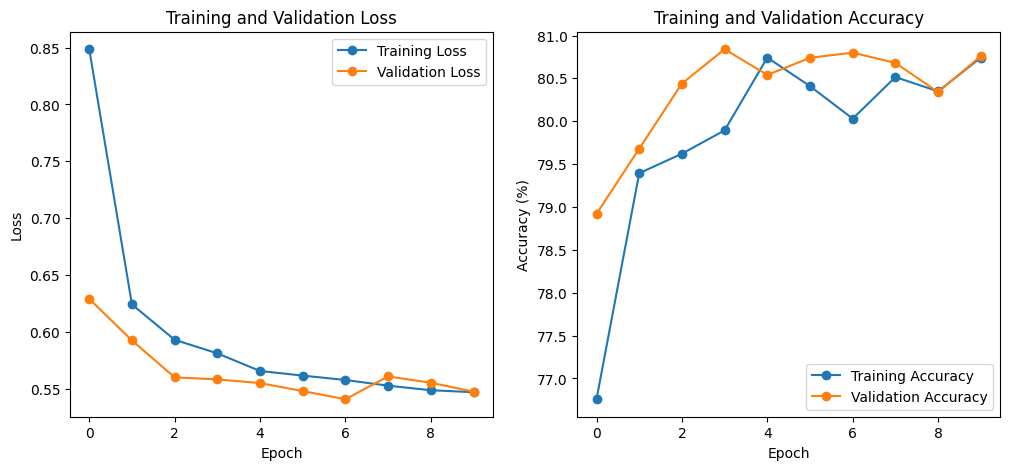

In [ ]:
# Same as above

## ResNet18 Net_Not_Fixed

Epoch 1, Batch 200, Loss: 0.763, Accuracy: 73.80%
Epoch 1, Batch 400, Loss: 0.537, Accuracy: 81.52%
Epoch 1, Batch 600, Loss: 0.472, Accuracy: 83.84%
Epoch 1 - Training Loss: 0.568, Accuracy: 84.83%, Validation Loss: 0.488, Accuracy: 83.52%
Epoch 2, Batch 200, Loss: 0.339, Accuracy: 88.48%
Epoch 2, Batch 400, Loss: 0.330, Accuracy: 88.92%
Epoch 2, Batch 600, Loss: 0.330, Accuracy: 88.60%
Epoch 2 - Training Loss: 0.330, Accuracy: 89.09%, Validation Loss: 0.355, Accuracy: 87.88%
Epoch 3, Batch 200, Loss: 0.199, Accuracy: 93.26%
Epoch 3, Batch 400, Loss: 0.236, Accuracy: 91.78%
Epoch 3, Batch 600, Loss: 0.243, Accuracy: 91.68%
Epoch 3 - Training Loss: 0.229, Accuracy: 91.74%, Validation Loss: 0.425, Accuracy: 86.60%
Epoch 4, Batch 200, Loss: 0.131, Accuracy: 95.32%
Epoch 4, Batch 400, Loss: 0.185, Accuracy: 93.58%
Epoch 4, Batch 600, Loss: 0.182, Accuracy: 93.54%
Epoch 4 - Training Loss: 0.166, Accuracy: 94.55%, Validation Loss: 0.358, Accuracy: 89.02%
Epoch 5, Batch 200, Loss: 0.101, Acc

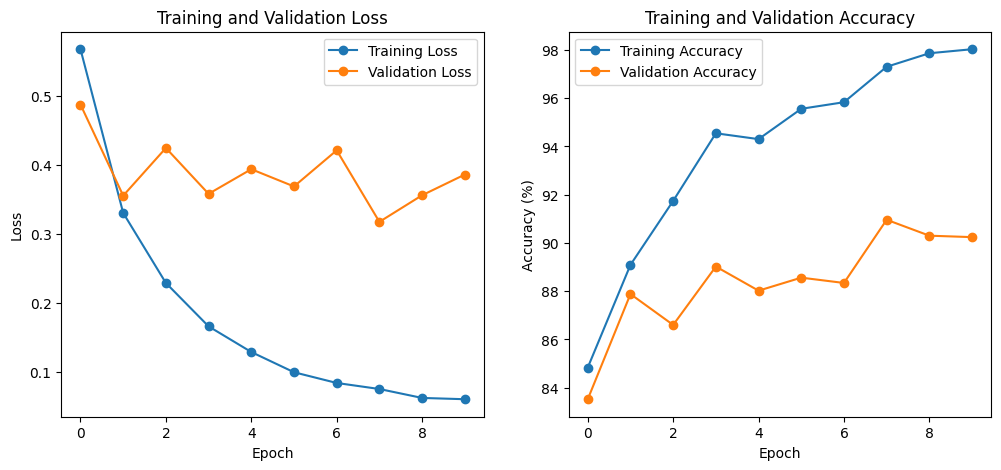

In [ ]:
# Step 2: Define the CNN architecture with pretrained resnet18
class Net_Not_Fixed(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet and modify it
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all the layers in the network
        for param in self.resnet.parameters():
            param.requires_grad = True

        # CIFAR-10 has 10 classes, modify the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)  # Adjust for 10 classes

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_not_fixed = Net_Not_Fixed().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_not_fixed = optim.Adam(net_not_fixed.parameters(), lr=0.001)

# Train the network
train_loss_not_fixed, train_acc_not_fixed, val_loss_not_fixed, val_acc_not_fixed = \
 train_and_evaluate(net_not_fixed, optimizer_not_fixed)

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
net_not_fixed.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_not_fixed(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_not_fixed, '-o',label='Training Loss')
plt.plot(val_loss_not_fixed, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_not_fixed,  '-o',label='Training Accuracy')
plt.plot(val_acc_not_fixed, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()



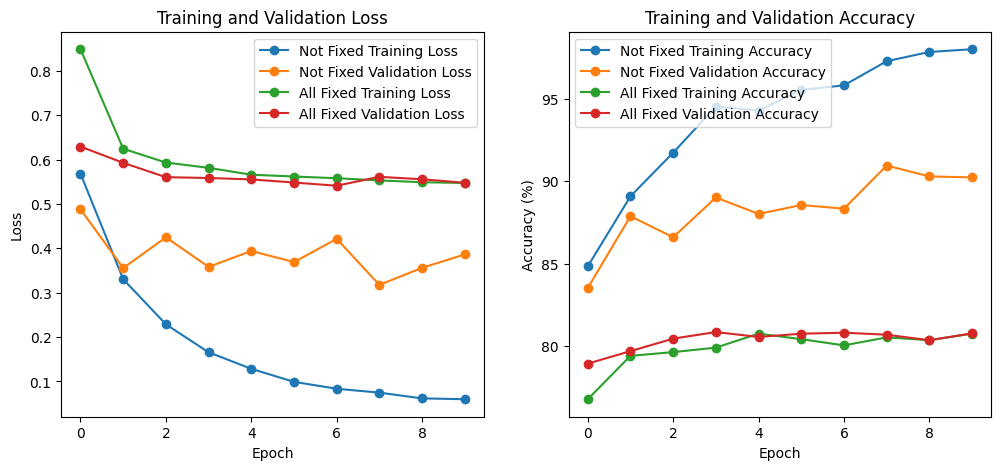

In [ ]:
# prompt: 2 plots to compare train_loss_not_fixed, val_loss_not_fixed, train_acc_not_fixed, val_acc_not_fixed, train_loss_all_fixed, train_acc_all_fixed, val_loss_all_fixed, val_acc_all_fixed

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_not_fixed, '-o',label='Not Fixed Training Loss')
plt.plot(val_loss_not_fixed, '-o', label='Not Fixed Validation Loss')
plt.plot(train_loss_all_fixed, '-o',label='All Fixed Training Loss')
plt.plot(val_loss_all_fixed, '-o', label='All Fixed Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_not_fixed,  '-o',label='Not Fixed Training Accuracy')
plt.plot(val_acc_not_fixed, '-o', label='Not Fixed Validation Accuracy')
plt.plot(train_acc_all_fixed,  '-o',label='All Fixed Training Accuracy')
plt.plot(val_acc_all_fixed, '-o', label='All Fixed Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


## ResNet18 Fixed Except the Last 3 Layers

Epoch 1, Batch 200, Loss: 0.764, Accuracy: 73.40%
Epoch 1, Batch 400, Loss: 0.543, Accuracy: 81.30%
Epoch 1, Batch 600, Loss: 0.469, Accuracy: 84.20%
Epoch 1 - Training Loss: 0.570, Accuracy: 85.30%, Validation Loss: 0.484, Accuracy: 83.66%
Epoch 2, Batch 200, Loss: 0.366, Accuracy: 87.48%
Epoch 2, Batch 400, Loss: 0.326, Accuracy: 88.90%
Epoch 2, Batch 600, Loss: 0.334, Accuracy: 88.52%
Epoch 2 - Training Loss: 0.338, Accuracy: 89.32%, Validation Loss: 0.404, Accuracy: 86.76%
Epoch 3, Batch 200, Loss: 0.215, Accuracy: 92.67%
Epoch 3, Batch 400, Loss: 0.229, Accuracy: 92.20%
Epoch 3, Batch 600, Loss: 0.242, Accuracy: 91.52%
Epoch 3 - Training Loss: 0.229, Accuracy: 92.12%, Validation Loss: 0.308, Accuracy: 89.40%
Epoch 4, Batch 200, Loss: 0.136, Accuracy: 95.29%
Epoch 4, Batch 400, Loss: 0.170, Accuracy: 93.93%
Epoch 4, Batch 600, Loss: 0.182, Accuracy: 93.72%
Epoch 4 - Training Loss: 0.167, Accuracy: 93.38%, Validation Loss: 0.314, Accuracy: 90.18%
Epoch 5, Batch 200, Loss: 0.118, Acc

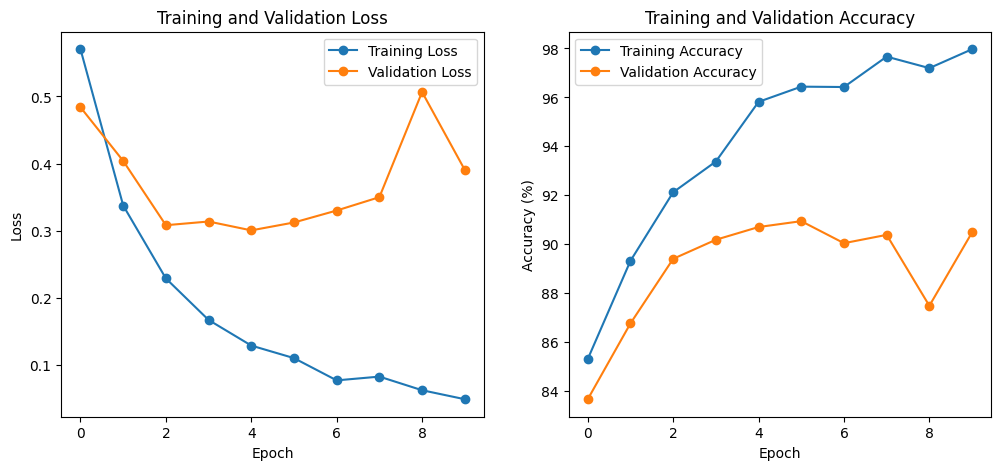

In [ ]:
# Step 2: Define the CNN architecture with pretrained resnet18
class Net_Ex3_Fixed(nn.Module):
    def __init__(self):
        super().__init__()
        # Load a pretrained ResNet and modify it
        self.resnet = models.resnet18(pretrained=True)

        # Freeze all the layers in the network
        for param in self.resnet.parameters():
            param.requires_grad = False

        for param in net_all_fixed.resnet.layer4[0].conv2.parameters():
          param.requires_grad = True

        for param in net_all_fixed.resnet.layer4[1].parameters():
          param.requires_grad = True

        # CIFAR-10 has 10 classes, modify the last fully connected layer
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)  # Adjust for 10 classes

    def forward(self, x):
        return self.resnet(x)

# Step 3: Setup GPU usage
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_ex3_fixed = Net_Ex3_Fixed().to(device)

# Step 4: Setup the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer_ex3_fixed = optim.Adam(net_ex3_fixed.parameters(), lr=0.001)

# Train the network
train_loss_gap_ex3_fixed, train_acc_ex3_fixed, val_loss_ex3_fixed, val_acc_ex3_fixed = \
 train_and_evaluate(net_ex3_fixed, optimizer_ex3_fixed)

# Step 6: Evaluate the network on the test data
correct = 0
total = 0
net_ex3_fixed.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net_ex3_fixed(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10,000 test images: {test_accuracy:.2f}%')

# Step 7: Plot the learning curves for accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_gap_ex3_fixed, '-o',label='Training Loss')
plt.plot(val_loss_ex3_fixed, '-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_ex3_fixed,  '-o',label='Training Accuracy')
plt.plot(val_acc_ex3_fixed, '-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()



In [ ]:
# prompt: save train_loss_not_fixed, val_loss_not_fixed, train_acc_not_fixed, val_acc_not_fixed, train_loss_all_fixed, train_acc_all_fixed, val_loss_all_fixed, val_acc_all_fixed, train_loss_gap_ex3_fixed, train_acc_ex3_fixed, val_loss_ex3_fixed, val_acc_ex3_fixed

import pickle

# Save the training and validation loss and accuracy for all three networks
with open('training_results.pkl', 'wb') as f:
  pickle.dump([train_loss_not_fixed, val_loss_not_fixed, train_acc_not_fixed, val_acc_not_fixed,
              train_loss_all_fixed, train_acc_all_fixed, val_loss_all_fixed, val_acc_all_fixed,
              train_loss_gap_ex3_fixed, train_acc_ex3_fixed, val_loss_ex3_fixed, val_acc_ex3_fixed], f)


In [ ]:
# prompt: Save the models net_ex3_fixed, net_not_fixed, net_all_fixed

torch.save(net_ex3_fixed.state_dict(), "net_ex3_fixed.pt")
torch.save(net_not_fixed.state_dict(), "net_not_fixed.pt")
torch.save(net_all_fixed.state_dict(), "net_all_fixed.pt")

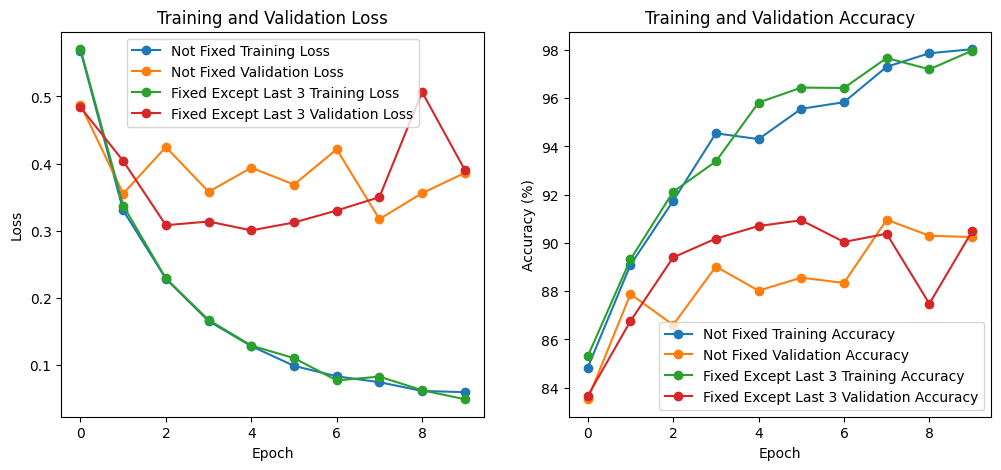

In [ ]:
# prompt: 2 plots to compare train_loss_not_fixed, train_acc_not_fixed, val_loss_not_fixed, val_acc_not_fixed, train_loss_gap_ex3_fixed, train_acc_ex3_fixed, val_loss_ex3_fixed, val_acc_ex3_fixed

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_not_fixed, '-o',label='Not Fixed Training Loss')
plt.plot(val_loss_not_fixed, '-o', label='Not Fixed Validation Loss')
plt.plot(train_loss_gap_ex3_fixed, '-o',label='Fixed Except Last 3 Training Loss')
plt.plot(val_loss_ex3_fixed, '-o', label='Fixed Except Last 3 Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_not_fixed,  '-o',label='Not Fixed Training Accuracy')
plt.plot(val_acc_not_fixed, '-o', label='Not Fixed Validation Accuracy')
plt.plot(train_acc_ex3_fixed,  '-o',label='Fixed Except Last 3 Training Accuracy')
plt.plot(val_acc_ex3_fixed, '-o', label='Fixed Except Last 3 Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


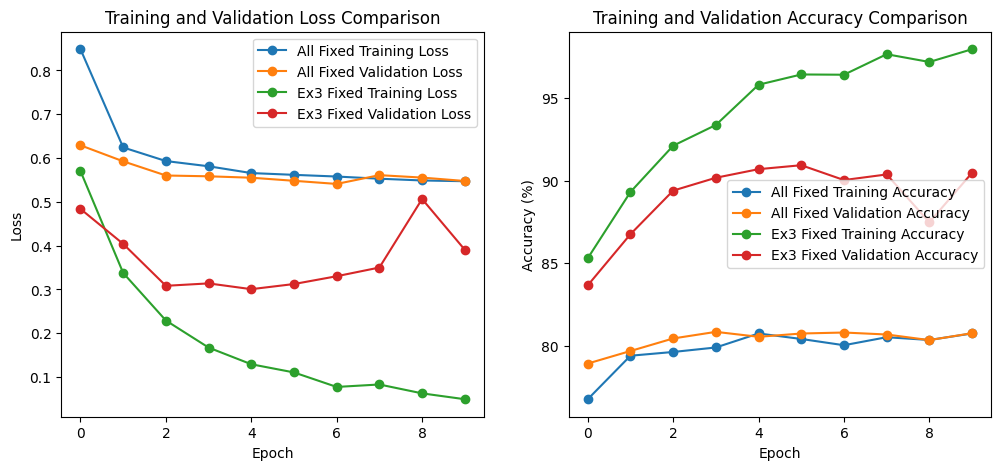

In [ ]:
# prompt: 2 plots to compare train_loss_all_fixed, train_acc_all_fixed, val_loss_all_fixed, val_acc_all_fixed, train_loss_gap_ex3_fixed, train_acc_ex3_fixed, val_loss_ex3_fixed, val_acc_ex3_fixed

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_all_fixed, '-o',label='All Fixed Training Loss')
plt.plot(val_loss_all_fixed, '-o', label='All Fixed Validation Loss')
plt.plot(train_loss_gap_ex3_fixed, '-o',label='Ex3 Fixed Training Loss')
plt.plot(val_loss_ex3_fixed, '-o', label='Ex3 Fixed Validation Loss')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_all_fixed,  '-o',label='All Fixed Training Accuracy')
plt.plot(val_acc_all_fixed, '-o', label='All Fixed Validation Accuracy')
plt.plot(train_acc_ex3_fixed,  '-o',label='Ex3 Fixed Training Accuracy')
plt.plot(val_acc_ex3_fixed, '-o', label='Ex3 Fixed Validation Accuracy')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


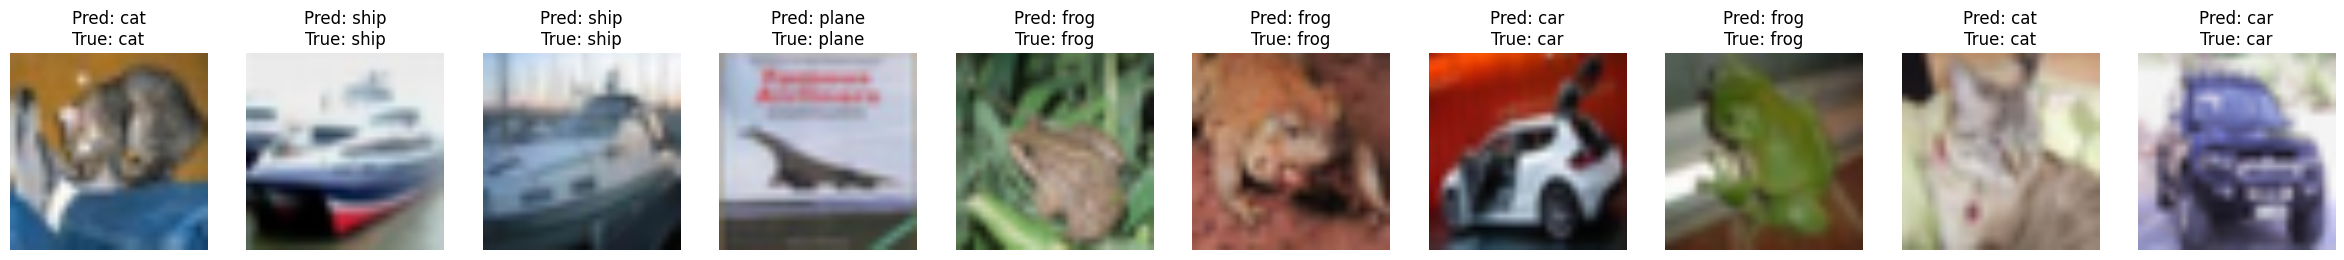

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(images, labels, predicted_labels):
    """Function to display images with labels and predictions"""
    # Set number of images to display
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 3, 3))

    for idx in range(num_images):
        ax = axes[idx]
        img = images[idx] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.axis('off')
        # Set title with predicted and true labels
        ax.set_title(f'Pred: {classes[predicted_labels[idx]]}\nTrue: {classes[labels[idx]]}')

# Load a batch of images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Predict labels
predicted_outputs = net(images.to(device))
_, predicted = torch.max(predicted_outputs, 1)

# Show images with annotations
imshow(images[:10], labels[:10], predicted[:10])
plt.show()


Predicted:  cat   ship  ship  plane frog 
True:       cat   ship  ship  plane frog 


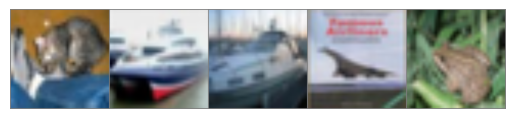

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:5]))
# Print labels
predicted_outputs = net(images.to(device))
_, predicted = torch.max(predicted_outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(5)))
print('True:      ', ' '.join(f'{classes[labels[j]]:5s}'
                              for j in range(5)))

plt.show()
